# Setting

In [84]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import requests  # API를 이용해 자료를 받아오기 위해

# 데이터 분석 라이브러리
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
# !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# 시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import folium
from folium.plugins import MarkerCluster, MiniMap

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

from matplotlib.ticker import FuncFormatter  # 필요한 모듈 가져오기

from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus
import json

# MySQL 연결 설정
host = 'da-4-1-db.c1widrnxppoz.ap-northeast-2.rds.amazonaws.com'  # 여기에 MySQL 서버의 호스트 주소 또는 IP 주소를 입력하세요
port = 3306
user = 'root'   
password = '9juvtDV9gG&[!'
database = 'JEJU_DB'
conn = pymysql.connect(host=host, port=port, user=user, password=password, database=database)

# KaKao API
KaKao_API_KEY = '3b61bd36d13f4d9e7646746c8ecb0ad1'

def Create_Table():
    df = pd.read_csv("제주특별자치도_버스노선현황.csv", encoding="cp949")
    ## csv read시 colum에 빈칸이 있으면 mysql에서 query 정상작동이 안됨;;
    table_name='제주특별자치도_버스노선현황'
    # 연결이 제대로 되었는지 확인
    if conn:
        print("MySQL에 성공적으로 연결되었습니다.")
        engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')
        df.to_sql(table_name, con=engine, if_exists='fail', index=False)
        # 연결 종료 
        # conn.close()
        print("Create Table Success.")
    else:
        print("MySQL 연결에 실패하였습니다.")

def Search_table_info():
    # 커서 생성
    cursor = conn.cursor()
    # 사용할 스키마 선택
    cursor.execute(f"USE {database};")

    # 선택된 스키마에 있는 테이블 목록 조회
    cursor.execute("SHOW TABLES;")
    tables = cursor.fetchall()

    # 선택된 스키마에 있는 테이블 목록 출력
    print(f"Tables in schema '{database}':")
    for table in tables:
        print(table[0])

    # 연결 종료
    # conn.close()

def to_dataFrame(table_name):
    # 사용할 스키마 선택
    cursor = conn.cursor()
    cursor.execute(f"USE {database};")

    # 테이블 데이터 가져오기
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql(query, conn)

    return df

def close_sql_server():
    conn.close()

def get_latitude_longitude(addresses):
    latitudes = []
    longitudes = []

    for address in addresses:
        url = f'https://dapi.kakao.com/v2/local/search/address.json?query={address}'
        headers = {'Authorization': f'KakaoAK {KaKao_API_KEY}'}
        response = requests.get(url, headers=headers)
        data = response.json()

        if 'documents' in data and len(data['documents']) > 0:
            result = data['documents'][0]
            x = result['x']
            y = result['y']
            latitudes.append(y)
            longitudes.append(x)
        else:
            latitudes.append(None)
            longitudes.append(None)

    return latitudes, longitudes


def get_address_from_coords(latitude, longitude):
    url = "https://dapi.kakao.com/v2/local/geo/coord2address"
    headers = {
        "Authorization": f"KakaoAK {KaKao_API_KEY}"
    }
    params = {
        "x": longitude,
        "y": latitude,
        "input_coord": "WGS84"
    }
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if 'documents' in data:
        return data['documents'][0]['address']['address_name']
    else:
        return "주소를 찾을 수 없습니다."

In [85]:
 # 서귀포시 동 리스트
seogwipo_dong = ['서귀포시','대정동', '남원동', '성산동', '안덕동', '표선동', '송산동', '정방동', '중앙동', '천지동', '효돈동', '영천동', '동홍동', '서홍동', '대륜동', '대천동', '중문동', '예래동',
                 '상예동', '하예동', '대포동', '하원동', '강정동', '법환동', '토평동', '하효동', '신효동', '서귀동', '월평동', '보목동', '도순동', '호근동','색달동'
                 ]
# 제주시 동 리스트
jeju_dong = ['제주시','일도1동', '일도2동','일도일동', '일도이동', '이도1동', '이도2동','이도일동', '이도이동', '삼도1동', '삼도2동','삼도일동', '삼도이동', 
                '용담1동', '용담2동', '건입동', '화북동', '삼양동', '봉개동',
                '도남동', '용담이동','용담일동', '도두이동', '도두일동', '도련일동',
                "용담삼동", "이호일동", "이호이동", "해안동", "내도동", "외도일동", "영평동",
                '아라동', '오라동','오라일동','오라이동','오라삼동', '연동', '노형동', '외도동', '이호동', '도두동']
# 제주도 읍/면 리스트
jeju_eup = ['애월읍', '한림읍', '한경면', '대정읍', '안덕면', '남원읍', '표선면', '성산읍', '우도면', '구좌읍', '조천읍','추자면']
  

In [86]:
# 'location' 컬럼 추가하는 함수 정의
def get_admin_location(emd):
    if emd in seogwipo_dong:
        return '서귀포시 동지역'
    elif emd in jeju_dong:
        return '제주시 동지역'
    elif emd in jeju_eup:
        return emd
    else:
        return None

In [87]:
Search_table_info()

Tables in schema 'JEJU_DB':
버스_노선_기본_정보
버스_정류소_기본_정보
서귀포_자전거_보관소_정보
월별버스이용자유형별패널티현황
읍면동_단위_내국인_유동인구
제주_공공와이파이_AP_정보
제주관광공사_제주관광정보시스템_콘텐츠
제주도_음식점
제주특별자치도_버스노선현황
제주특별자치도_서귀포시내버스노선현황
제주특별자치도_제주시_자전거대여소
제주특별자치도_제주시내버스노선현황
카셰어링_업체_위치_정보


# 데이터 분석

## 1. 유동인구

In [88]:
population_df=to_dataFrame('읍면동_단위_내국인_유동인구')
population_df['totalPop']=population_df['resdPop']+population_df['workPop']+population_df['visitPop']
population_df

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\149725057.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,baseDate,city,emd,gender,ageGroup,resdPop,workPop,visitPop,totalPop
0,20210101,제주시,한림읍,남,20대,25079,1937,11423,38439
1,20210101,제주시,한림읍,여,80대이상,8312,374,862,9548
2,20210101,제주시,애월읍,남,70대,31185,1745,4839,37769
3,20210101,제주시,구좌읍,남,70대,16284,396,1385,18065
4,20210101,제주시,조천읍,남,40대,44349,3853,21718,69920
...,...,...,...,...,...,...,...,...,...
469813,20231231,제주시,조천읍,여,80대이상,209639,8275,145719,363633
469814,20231231,제주시,봉개동,남,80대이상,33550,2683,29252,65485
469815,20231231,제주시,봉개동,여,80대이상,30146,1736,28758,60640
469816,20231231,서귀포시,정방동,남,80대이상,21579,3087,40883,65549


In [89]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469818 entries, 0 to 469817
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   baseDate  469818 non-null  object
 1   city      469818 non-null  object
 2   emd       469818 non-null  object
 3   gender    469818 non-null  object
 4   ageGroup  469818 non-null  object
 5   resdPop   469818 non-null  int64 
 6   workPop   469818 non-null  int64 
 7   visitPop  469818 non-null  int64 
 8   totalPop  469818 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 32.3+ MB


In [90]:
jeju_admin_district_df=population_df[['baseDate','emd','city','totalPop']]
jeju_admin_district_df=jeju_admin_district_df.reset_index()
jeju_admin_district_df.drop(columns='index',inplace=True)

# 'location' 컬럼 추가
jeju_admin_district_df['location'] = jeju_admin_district_df['emd'].apply(get_admin_location)
jeju_admin_district_df

,baseDate,emd,city,totalPop,location
0,20210101,한림읍,제주시,38439,한림읍
1,20210101,한림읍,제주시,9548,한림읍
2,20210101,애월읍,제주시,37769,애월읍
3,20210101,구좌읍,제주시,18065,구좌읍
4,20210101,조천읍,제주시,69920,조천읍
...,...,...,...,...,...
469813,20231231,조천읍,제주시,363633,조천읍
469814,20231231,봉개동,제주시,65485,제주시 동지역
469815,20231231,봉개동,제주시,60640,제주시 동지역
469816,20231231,정방동,서귀포시,65549,서귀포시 동지역


In [91]:
jeju_admin_district_df.groupby('location')['totalPop'].sum().reset_index().sort_values(by='totalPop', ascending=False)

,location,totalPop
8,제주시 동지역,12498553136
3,서귀포시 동지역,3359514053
6,애월읍,1384404075
9,조천읍,817516101
13,한림읍,766248839
...,...,...
0,구좌읍,554696168
11,표선면,443517859
12,한경면,292654243
7,우도면,67833906


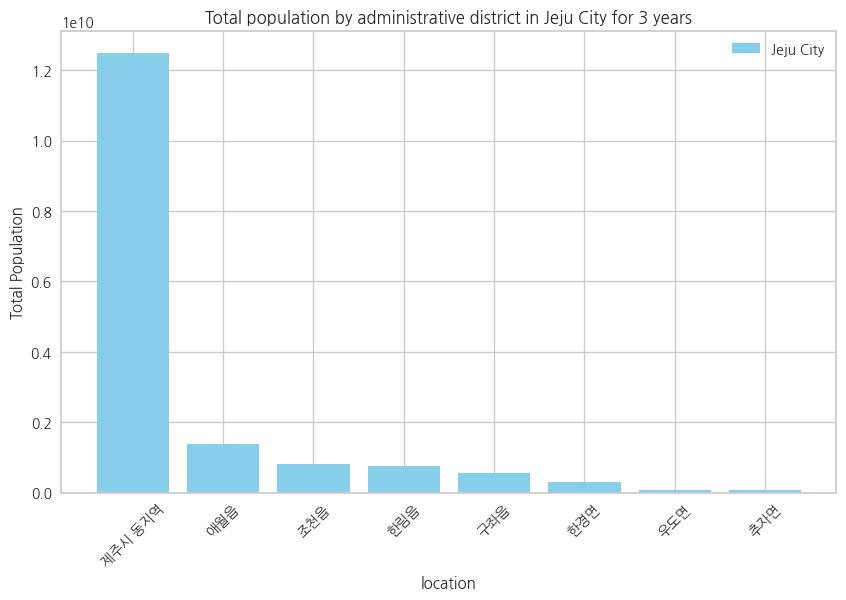

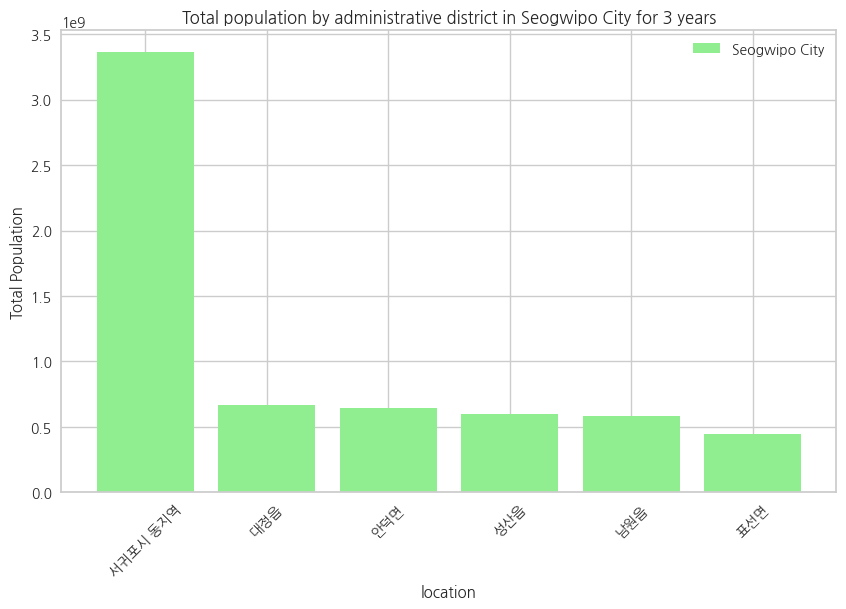

In [92]:
# 제주시와 서귀포시로 데이터 필터링
jejusi_data = jeju_admin_district_df[jeju_admin_district_df['city'] == '제주시']
seogwipo_data = jeju_admin_district_df[jeju_admin_district_df['city'] == '서귀포시']

# 각 도시별 'location'별로 'totalPop'의 합계 계산
jejusi_grouped_data = jejusi_data.groupby('location')['totalPop'].sum().reset_index()
seogwipo_grouped_data = seogwipo_data.groupby('location')['totalPop'].sum().reset_index()

# 각 도시별로 'totalPop'이 많은 순으로 정렬
sorted_jejusi_data = jejusi_grouped_data.sort_values(by='totalPop', ascending=False)
sorted_seogwipo_data = seogwipo_grouped_data.sort_values(by='totalPop', ascending=False)

# 제주시 데이터 시각화
plt.figure(figsize=(10, 6))
plt.bar(sorted_jejusi_data['location'], sorted_jejusi_data['totalPop'], color='skyblue', label='Jeju City')
plt.title('Total population by administrative district in Jeju City for 3 years')
plt.xlabel('location')
plt.ylabel('Total Population')
plt.xticks(rotation=45)
plt.legend()  # 범례 추가
plt.show()

# 서귀포시 데이터 시각화
plt.figure(figsize=(10, 6))
plt.bar(sorted_seogwipo_data['location'], sorted_seogwipo_data['totalPop'], color='lightgreen', label='Seogwipo City')
plt.title('Total population by administrative district in Seogwipo City for 3 years')
plt.xlabel('location')
plt.ylabel('Total Population')
plt.xticks(rotation=45)
plt.legend()  # 범례 추가
plt.show()


In [93]:
# 'city' 열을 DataFrame의 맨 앞에 추가하기
jesu_population_df=pd.concat([jejusi_grouped_data,seogwipo_grouped_data])

Representative_locations_Info = [
    {'지역': '구좌읍','장소': '메인동산', '도로명주소': '제주 제주시 구좌읍 한동리', '속한 지역': jeju_eup},
    {'지역': '남원읍','장소': '제주동백수목원', '도로명주소': '제주 서귀포시 남원읍 위미리 929-2', '속한 지역': jeju_eup},
    {'지역': '대정읍', '장소': '모슬봉', '도로명주소': '제주 서귀포시 대정읍 동일리 2081-3', '속한 지역': jeju_eup},
    {'지역': '서귀포시 동지역', '장소': '월산봉', '도로명주소': '제주 서귀포시 중산간서로 95', '속한 지역': seogwipo_dong},
    {'지역': '성산읍', '장소': '제주해양동물박물관', '도로명주소': '제주 서귀포시 성산읍 서성일로 689-21', '속한 지역': jeju_eup},
    {'지역': '안덕면', '장소': '논오름', '도로명주소': '제주 서귀포시 안덕면 상창리', '속한 지역': jeju_eup},
    {'지역': '애월읍', '장소': '눈오름', '도로명주소': '제주 제주시 애월읍 장전리', '속한 지역': jeju_eup},
    {'지역': '우도면', '장소': '소머리오름', '도로명주소': '제주 제주시 우도면 연평리 산18-2', '속한 지역': jeju_eup},
    {'지역': '제주시 동지역', '장소': '제주공항', '도로명주소': '제주 제주시 공항로 2 제주국제공항', '속한 지역': jeju_dong},
    {'지역': '조천읍', '장소': '본술산', '도로명주소': '제주 제주시 조천읍 대흘리', '속한 지역': jeju_eup},
    {'지역': '추자면', '장소': '추자도등대', '도로명주소': '제주 제주시 추자면 영흥리 77-3', '속한 지역': jeju_eup},
    {'지역': '표선면', '장소': '제주민속촌', '도로명주소': '제주 서귀포시 표선면 민속해안로 631-34', '속한 지역': jeju_eup},
    {'지역': '한경면', '장소': '아홉굿마을', '도로명주소': '제주 제주시 한경면 낙수로 97', '속한 지역': jeju_eup},
    {'지역': '한림읍', '장소': '한림공원', '도로명주소': '제주 제주시 한림읍 한림로 300', '속한 지역': jeju_eup}
]

# 장소 및 도로명 주소 정보 추가
for location_info in Representative_locations_Info:
    # 해당 지역과 일치하는 데이터 찾기
    mask = jesu_population_df['location'] == location_info['지역']
    
    # 해당 지역과 일치하는 데이터에 장소 정보 및 도로명 주소 추가
    jesu_population_df.loc[mask, ['장소', '도로명주소']] = location_info['장소'], location_info['도로명주소']

jesu_population_df['latitude'],jesu_population_df['longitude']=get_latitude_longitude(jesu_population_df['도로명주소'])

# 인덱스 다시 설정
jesu_population_df.index = range(len(jesu_population_df))
jesu_population_df

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\669341345.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '메인동산' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  jesu_population_df.loc[mask, ['장소', '도로명주소']] = location_info['장소'], location_info['도로명주소']
C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\669341345.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '제주 제주시 구좌읍 한동리' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  jesu_population_df.loc[mask, ['장소', '도로명주소']] = location_info['장소'], location_info['도로명주소']


,location,totalPop,장소,도로명주소,latitude,longitude
0,구좌읍,554696168,메인동산,제주 제주시 구좌읍 한동리,33.5250247566996,126.816164035762
1,애월읍,1384404075,눈오름,제주 제주시 애월읍 장전리,33.4486238312794,126.387472960383
2,우도면,67833906,소머리오름,제주 제주시 우도면 연평리 산18-2,33.4925956178596,126.964240571646
3,제주시 동지역,12498553136,제주공항,제주 제주시 공항로 2 제주국제공항,33.5059364682672,126.495951277797
4,조천읍,817516101,본술산,제주 제주시 조천읍 대흘리,33.4996730708539,126.662508048026
...,...,...,...,...,...,...
9,대정읍,666324465,모슬봉,제주 서귀포시 대정읍 동일리 2081-3,33.2386106145828,126.258210198215
10,서귀포시 동지역,3359514053,월산봉,제주 서귀포시 중산간서로 95,33.2598740836071,126.501775286788
11,성산읍,599934351,제주해양동물박물관,제주 서귀포시 성산읍 서성일로 689-21,33.4294862344343,126.855127407133
12,안덕면,647815296,논오름,제주 서귀포시 안덕면 상창리,33.2828926479524,126.359168662669


In [94]:

# totalPop을 기준으로 4분위수를 계산합니다.
quantiles = jesu_population_df['totalPop'].quantile([0.25, 0.5, 0.75])

# 각 위치별 totalPop이 속하는 분위수를 계산합니다.
def get_color(population):
    if population <= quantiles[0.25]:
        return 'green'  # 1분위
    elif population <= quantiles[0.5]:
        return 'blue'  # 2분위
    elif population <= quantiles[0.75]:
        return 'orange'  # 3분위
    else:
        return 'red'  # 4분위

# 지도 중심 위치 설정
map_center = [33.38, 126.53]  # 제주시 중심 좌표

# 지도 생성
map = folium.Map(location=map_center, zoom_start=10)

# 데이터프레임에서 위치 정보를 반복하여 마커 생성
for index, row in jesu_population_df.iterrows():
    popup_text = f"Location: {row['location']}<br>Total Population: {row['totalPop']}<br>Address: {row['도로명주소']}"
    folium.Marker(location=[row['latitude'], row['longitude']], popup=popup_text, icon=folium.Icon(color=get_color(row['totalPop']))).add_to(map)

# 지도를 HTML 파일로 저장
map.save('map.html')

# 생성한 지도를 출력
map


## 2. 교통수단 인프라 현황

### 버스 정류장 데이터 전처리 및 현황


In [95]:
bus_df=to_dataFrame('버스_정류소_기본_정보')
bus_df

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\149725057.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,stationId,stationType,stationName,stationAddress,direction,longitude,latitude,localInfo
0,406001168,기타,(구)구판장,서귀포시 표선면 세화리,통과노선없음,126.797879,33.329732,세화1리노인회관입구
1,406001167,현대카드,(구)구판장,서귀포시 표선면 세화리,통과노선없음,126.798051,33.329675,세화1리노인회관입구
2,405000186,현대카드,(구)삼양검문소,제주시 삼양동,서귀-제주,126.600034,33.521022,자연농원 우측
3,405000185,현대카드,(구)삼양검문소,제주시 조천읍,제주-서귀,126.600847,33.520956,조천읍이정표 좌측
4,406001176,각주형,(구)중앙파출소,서귀포시 천지동,중앙R-보목,126.56089,33.247515,에이스모텔(후문) 앞
...,...,...,...,...,...,...,...,...
4128,405001115,표지판형,흥국사,제주시 애월읍,한림-제주,126.37774,33.452319,용흥3길이정표앞
4129,406001767,일반형,흥덕사,,,126.876005,33.399031,
4130,406001766,일반형,흥덕사,,,126.876066,33.399128,
4131,406001056,감귤형,희진주유소,서귀포시 성산읍 신산리,제주-서귀,126.874037,33.377568,희진주유소 앞


In [96]:
bus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4133 entries, 0 to 4132
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   stationId       4133 non-null   object
 1   stationType     4133 non-null   object
 2   stationName     4133 non-null   object
 3   stationAddress  4133 non-null   object
 4   direction       4133 non-null   object
 5   longitude       4133 non-null   object
 6   latitude        4133 non-null   object
 7   localInfo       4133 non-null   object
dtypes: object(8)
memory usage: 258.4+ KB


In [97]:
bus_df=bus_df[['latitude','longitude','stationName','stationAddress']]

for i in range(len(bus_df)):
    if bus_df.loc[i, 'stationAddress'] == '':
        try:
            address = get_address_from_coords(bus_df.loc[i, 'latitude'], bus_df.loc[i, 'longitude'])
            bus_df.loc[i, 'stationAddress'] = address
        except Exception as e:
            print(f"API 호출 중 오류 발생: {e}")
bus_df = bus_df.drop_duplicates()
bus_df

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\430729448.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df.loc[i, 'stationAddress'] = address


API 호출 중 오류 발생: list index out of range
API 호출 중 오류 발생: list index out of range
API 호출 중 오류 발생: list index out of range
API 호출 중 오류 발생: list index out of range
API 호출 중 오류 발생: list index out of range
API 호출 중 오류 발생: list index out of range


,latitude,longitude,stationName,stationAddress
0,33.329732,126.797879,(구)구판장,서귀포시 표선면 세화리
1,33.329675,126.798051,(구)구판장,서귀포시 표선면 세화리
2,33.521022,126.600034,(구)삼양검문소,제주시 삼양동
3,33.520956,126.600847,(구)삼양검문소,제주시 조천읍
4,33.247515,126.56089,(구)중앙파출소,서귀포시 천지동
...,...,...,...,...
4128,33.452319,126.37774,흥국사,제주시 애월읍
4129,33.399031,126.876005,흥덕사,제주특별자치도 서귀포시 성산읍 난산리 224-2
4130,33.399128,126.876066,흥덕사,제주특별자치도 서귀포시 성산읍 난산리 405-1
4131,33.377568,126.874037,희진주유소,서귀포시 성산읍 신산리


In [98]:
bus_df['emd']=''

# 데이터프레임의 'stationAddress' 열에서 각 지명이 포함된 행을 찾고 'emd' 컬럼에 해당 위치를 할당합니다.
for location in seogwipo_dong + jeju_dong + jeju_eup:
    mask = bus_df['stationAddress'].str.contains(location)
    if mask.any():
        # 해당 지명이 포함된 행의 인덱스를 가져옵니다.
        indices = bus_df[mask].index
        
        # 해당 행들의 'emd' 컬럼에 해당 위치를 할당합니다.
        bus_df.loc[indices, 'emd'] = location

# 'location' 컬럼 추가
bus_df['location'] = bus_df['emd'].apply(get_admin_location)

bus_df

,latitude,longitude,stationName,stationAddress,emd,location
0,33.329732,126.797879,(구)구판장,서귀포시 표선면 세화리,표선면,표선면
1,33.329675,126.798051,(구)구판장,서귀포시 표선면 세화리,표선면,표선면
2,33.521022,126.600034,(구)삼양검문소,제주시 삼양동,삼양동,제주시 동지역
3,33.520956,126.600847,(구)삼양검문소,제주시 조천읍,조천읍,조천읍
4,33.247515,126.56089,(구)중앙파출소,서귀포시 천지동,천지동,서귀포시 동지역
...,...,...,...,...,...,...
4128,33.452319,126.37774,흥국사,제주시 애월읍,애월읍,애월읍
4129,33.399031,126.876005,흥덕사,제주특별자치도 서귀포시 성산읍 난산리 224-2,성산읍,성산읍
4130,33.399128,126.876066,흥덕사,제주특별자치도 서귀포시 성산읍 난산리 405-1,성산읍,성산읍
4131,33.377568,126.874037,희진주유소,서귀포시 성산읍 신산리,성산읍,성산읍


In [99]:
bus_df.dropna(inplace=True)
bus_df.isna().sum()

latitude          0
longitude         0
stationName       0
stationAddress    0
emd               0
location          0
dtype: int64

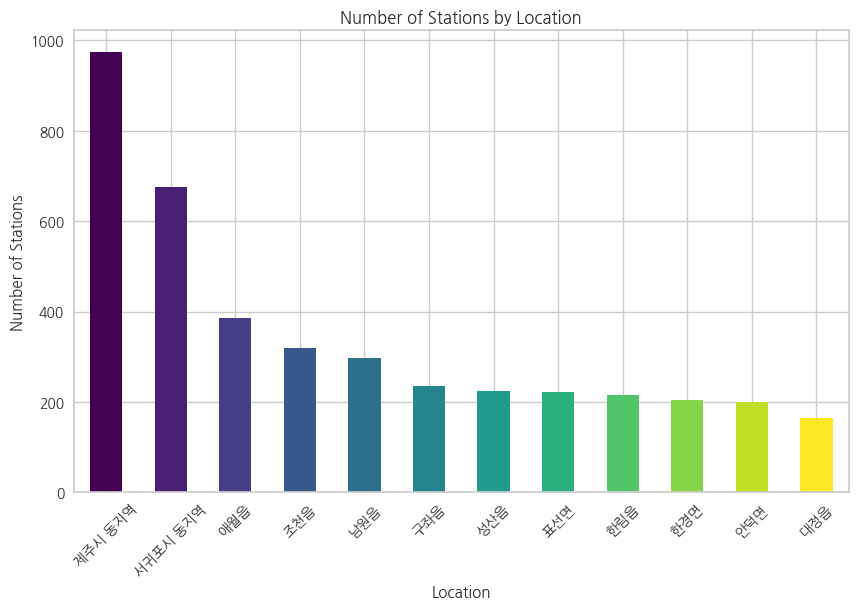

In [100]:
# location별 정류장 개수 계산
bus_counts = bus_df['location'].value_counts()

# colormap 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(bus_counts)))

# 막대 그래프 생성
plt.figure(figsize=(10, 6))
bus_counts.plot(kind='bar', color=colors)
plt.title('Number of Stations by Location')
plt.xlabel('Location')
plt.ylabel('Number of Stations')
plt.xticks(rotation=45)
plt.show()

In [101]:
from sklearn.covariance import EllipticEnvelope

# 'latitude'와 'longitude' 열을 숫자형으로 변환
bus_df['latitude'] = bus_df['latitude'].astype(float)
bus_df['longitude'] = bus_df['longitude'].astype(float)

# 이상치 감지 함수 정의
def detect_outliers(data):
    envelope = EllipticEnvelope(contamination=0.01)  # 이상치 비율 설정
    envelope.fit(data)
    outliers = envelope.predict(data)
    return outliers

# 위치별로 정류장의 평균 위경도 계산
location_coords = bus_df.groupby('location')[['latitude', 'longitude']].mean().reset_index()

# 이상치 감지
outliers = detect_outliers(location_coords[['latitude', 'longitude']])

# 이상치가 아닌 데이터만 선택
location_coords = location_coords[outliers == 1]

# 정류장 개수에 따라 색상 지정
location_counts = bus_df['location'].value_counts()
quantiles = location_counts.quantile([0.25, 0.5, 0.75])

def get_color(count):
    if count > quantiles[0.75]:
        return 'red'
    elif count > quantiles[0.5]:
        return 'orange'
    elif count > quantiles[0.25]:
        return 'blue'
    else:
        return 'green'

# 지도 중심 위치 설정 (위경도의 평균 값 사용)
map_center = [location_coords['latitude'].mean(), location_coords['longitude'].mean()]

# 지도 생성
map = folium.Map(location=map_center, zoom_start=10)

# 각 위치별로 정류장 개수를 지도에 추가
for index, row in location_coords.iterrows():
    location = row['location']
    count = bus_df[bus_df['location'] == location]['location'].count()  # 해당 위치의 정류장 개수 계산
    color = get_color(count)
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup=f"{location}: {count} stations",
                  icon=folium.Icon(color=color)).add_to(map)

# 지도를 HTML 파일로 저장
map.save('map_with_colored_markers.html')

# 생성한 지도를 출력
map


### 자전거, 렌트카 데이터 전처리 및 현황


In [102]:
# CSV 파일 읽기
bike = to_dataFrame('서귀포_자전거_보관소_정보')
bike2 = to_dataFrame('제주특별자치도_제주시_자전거대여소')

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\149725057.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [103]:
bike.rename(columns={'name': '점포 이름'}, inplace=True)
bike=bike[['latitude', 'longitude', '점포 이름']]

bike2.rename(columns={'자전거대여소명': '점포 이름'}, inplace=True)
bike2.rename(columns={'위도': 'latitude'}, inplace=True)
bike2.rename(columns={'경도': 'longitude'}, inplace=True)
bike2=bike2[['latitude', 'longitude', '점포 이름']]

bike_df = pd.concat([bike, bike2], ignore_index=True)

# 중복된 행 삭제
bike_df = bike_df.drop_duplicates()

# 'latitude' 열의 값을 숫자(float)로 변환
bike_df['latitude'] = pd.to_numeric(bike_df['latitude'], errors='coerce')
bike_df['longitude'] = pd.to_numeric(bike_df['longitude'], errors='coerce')

In [104]:
bike_df

,latitude,longitude,점포 이름
0,33.279870,126.720648,남원읍사무소 주차장 옆
1,33.210826,126.263008,하수해수욕장 동쪽주차장
2,33.251181,126.323160,덕수리 조각공원 주차장
3,33.255429,126.329073,화순리 산방도서관
4,33.298081,126.312298,화순리 구면사무소
...,...,...,...
152,33.491059,126.486042,연동 롯데시티호텔 뒤 주차장내
153,33.500167,126.529660,이도2동 벤처마루 앞
154,33.510746,126.543517,일도2동 영락교회 앞
155,33.518148,126.523955,삼도2동 탑동해변공연장


In [105]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   157 non-null    float64
 1   longitude  157 non-null    float64
 2   점포 이름      157 non-null    object 
dtypes: float64(2), object(1)
memory usage: 3.8+ KB


In [106]:
# CSV 파일 읽기
car_df = to_dataFrame('카셰어링_업체_위치_정보')
car_df

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\149725057.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,placeName,category,addressJibun,addressDoro,longitude,latitude,placeUrl
0,샤인렌트카,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 이도이동 1024-13,제주특별자치도 제주시 구남로7길 13-7,126.533619,33.494112,http://place.map.kakao.com/7940644
1,제주이브이전기렌트카,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 이도일동 1245-26,제주특별자치도 제주시 동광로 43,126.533096,33.502846,http://place.map.kakao.com/1293687082
2,에이치비소프트,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 삼도이동 154,제주특별자치도 제주시 중앙로14길 21,126.522086,33.510852,http://place.map.kakao.com/1448975371
3,썸타는우도전기차,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 우도면 연평리 1737-3,제주특별자치도 제주시 우도면 우도해안길 61,126.951953,33.492656,http://place.map.kakao.com/433902724
4,자보렌트카,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 오라이동 2213-2,제주특별자치도 제주시 오라로 66,126.510127,33.495504,http://place.map.kakao.com/2001392507
...,...,...,...,...,...,...,...
210,쏘카존 제주신화월드 직원기숙사 H관,"교통,수송 > 교통시설 > 카셰어링 > 쏘카존",제주특별자치도 서귀포시 안덕면 서광리 산 35-22,제주특별자치도 서귀포시 안덕면 신화역사로188번길 151,126.307944,33.296845,http://place.map.kakao.com/1081616582
211,쏘카존 제주신화월드 랜딩관,"교통,수송 > 교통시설 > 카셰어링 > 쏘카존",제주특별자치도 서귀포시 안덕면 서광리 산 24,제주특별자치도 서귀포시 안덕면 신화역사로304번길 38,126.317750,33.304345,http://place.map.kakao.com/454043887
212,쏘카존 켄싱턴리조트 제주중문,"교통,수송 > 교통시설 > 카셰어링 > 쏘카존",제주특별자치도 서귀포시 색달동 2822-4,제주특별자치도 서귀포시 중문관광로72번길 29-29,126.412109,33.248318,http://place.map.kakao.com/26352217
213,쏘카존 소노벨제주,"교통,수송 > 교통시설 > 카셰어링 > 쏘카존",제주특별자치도 제주시 조천읍 함덕리 274,제주특별자치도 제주시 조천읍 신북로 577,126.671960,33.540829,http://place.map.kakao.com/44887001


In [107]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   placeName     215 non-null    object 
 1   category      215 non-null    object 
 2   addressJibun  215 non-null    object 
 3   addressDoro   215 non-null    object 
 4   longitude     215 non-null    float64
 5   latitude      215 non-null    float64
 6   placeUrl      215 non-null    object 
dtypes: float64(2), object(5)
memory usage: 11.9+ KB


In [108]:
# 중복된 행 삭제
car_df = car_df.drop_duplicates()

# 'latitude' 열의 값을 숫자(float)로 변환
car_df['latitude'] = pd.to_numeric(car_df['latitude'], errors='coerce')
car_df['longitude'] = pd.to_numeric(car_df['longitude'], errors='coerce')

car_df.rename(columns={'placeName': '점포 이름'}, inplace=True)

In [109]:
set(car_df['category'].tolist())

{'교통,수송 > 교통시설 > 카셰어링',
 '교통,수송 > 교통시설 > 카셰어링 > 쏘카존',
 '서비스,산업 > 전문대행 > 렌터카',
 '서비스,산업 > 전문대행 > 렌터카 > SK렌터카',
 '서비스,산업 > 전문대행 > 렌터카 > 롯데렌터카'}

In [110]:
car_df = car_df[(car_df['category'] == '서비스,산업 > 전문대행 > 렌터카') | 
                (car_df['category'] == '서비스,산업 > 전문대행 > 렌터카 > SK렌터카') |
                (car_df['category'] == '서비스,산업 > 전문대행 > 렌터카 > 롯데렌터카')]
car_df

,점포 이름,category,addressJibun,addressDoro,longitude,latitude,placeUrl
0,샤인렌트카,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 이도이동 1024-13,제주특별자치도 제주시 구남로7길 13-7,126.533619,33.494112,http://place.map.kakao.com/7940644
1,제주이브이전기렌트카,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 이도일동 1245-26,제주특별자치도 제주시 동광로 43,126.533096,33.502846,http://place.map.kakao.com/1293687082
2,에이치비소프트,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 삼도이동 154,제주특별자치도 제주시 중앙로14길 21,126.522086,33.510852,http://place.map.kakao.com/1448975371
3,썸타는우도전기차,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 우도면 연평리 1737-3,제주특별자치도 제주시 우도면 우도해안길 61,126.951953,33.492656,http://place.map.kakao.com/433902724
4,자보렌트카,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 오라이동 2213-2,제주특별자치도 제주시 오라로 66,126.510127,33.495504,http://place.map.kakao.com/2001392507
...,...,...,...,...,...,...,...
179,제주캐스팅투어,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 외도일동 405-4,제주특별자치도 제주시 일주서로 7326,126.429846,33.492653,http://place.map.kakao.com/27339236
187,탐라렌트카,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 서귀포시 하효동 509,제주특별자치도 서귀포시 과원동로12번길 11-3,126.620126,33.260190,http://place.map.kakao.com/18211713
188,제주친구,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 서귀포시 동홍동 1255-2,제주특별자치도 서귀포시 동홍로 149,126.567076,33.261787,http://place.map.kakao.com/370536784
189,찜카,"서비스,산업 > 전문대행 > 렌터카",제주특별자치도 제주시 영평동 2193,제주특별자치도 제주시 첨단로 330,126.571451,33.442338,http://place.map.kakao.com/921721117


### 도로명 주소 및 행정구역 컬럼 생성

In [111]:
bike_df=bike_df[['latitude','longitude','점포 이름']]

for i in range(len(bike_df)):
    try:
        address = get_address_from_coords(bike_df.loc[i, 'latitude'], bike_df.loc[i, 'longitude'])
        bike_df.loc[i, 'stationAddress'] = address
    except Exception as e:
        print(f"API 호출 중 오류 발생: {e}")

bike_df['emd']=''

# 데이터프레임의 'stationAddress' 열에서 각 지명이 포함된 행을 찾고 'emd' 컬럼에 해당 위치를 할당합니다.
for location in seogwipo_dong + jeju_dong + jeju_eup:
    mask = bike_df['stationAddress'].str.contains(location)
    if mask.any():
        # 해당 지명이 포함된 행의 인덱스를 가져옵니다.
        indices = bike_df[mask].index
        
        # 해당 행들의 'emd' 컬럼에 해당 위치를 할당합니다.
        bike_df.loc[indices, 'emd'] = location

# 'location' 컬럼 추가
bike_df['location'] = bike_df['emd'].apply(get_admin_location)

bike_df.dropna(inplace=True)
bike_df.isna().sum()

API 호출 중 오류 발생: ('Connection aborted.', ConnectionResetError(10054, '현재 연결은 원격 호스트에 의해 강제로 끊겼습니다', None, 10054, None))


latitude          0
longitude         0
점포 이름             0
stationAddress    0
emd               0
location          0
dtype: int64

In [112]:
car_df=car_df[['latitude','longitude','점포 이름']]

for i in range(len(car_df)):
    try:
        address = get_address_from_coords(car_df.loc[i, 'latitude'], car_df.loc[i, 'longitude'])
        car_df.loc[i, 'stationAddress'] = address
    except Exception as e:
        print(f"API 호출 중 오류 발생: {e}")

car_df['emd']=''

# 데이터프레임의 'stationAddress' 열에서 각 지명이 포함된 행을 찾고 'emd' 컬럼에 해당 위치를 할당합니다.
for location in seogwipo_dong + jeju_dong + jeju_eup:
    mask = car_df['stationAddress'].str.contains(location)
    if mask.any():
        # 해당 지명이 포함된 행의 인덱스를 가져옵니다.
        indices = car_df[mask].index
        
        # 해당 행들의 'emd' 컬럼에 해당 위치를 할당합니다.
        car_df.loc[indices, 'emd'] = location

# 'location' 컬럼 추가
car_df['location'] = car_df['emd'].apply(get_admin_location)

car_df.dropna(inplace=True)
car_df.isna().sum()

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\940986995.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df.loc[i, 'stationAddress'] = address


API 호출 중 오류 발생: 177
API 호출 중 오류 발생: 178
API 호출 중 오류 발생: 180
API 호출 중 오류 발생: 181


C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\940986995.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['emd']=''
C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\940986995.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['location'] = car_df['emd'].apply(get_admin_location)
C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\940986995.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

latitude          0
longitude         0
점포 이름             0
stationAddress    0
emd               0
location          0
dtype: int64

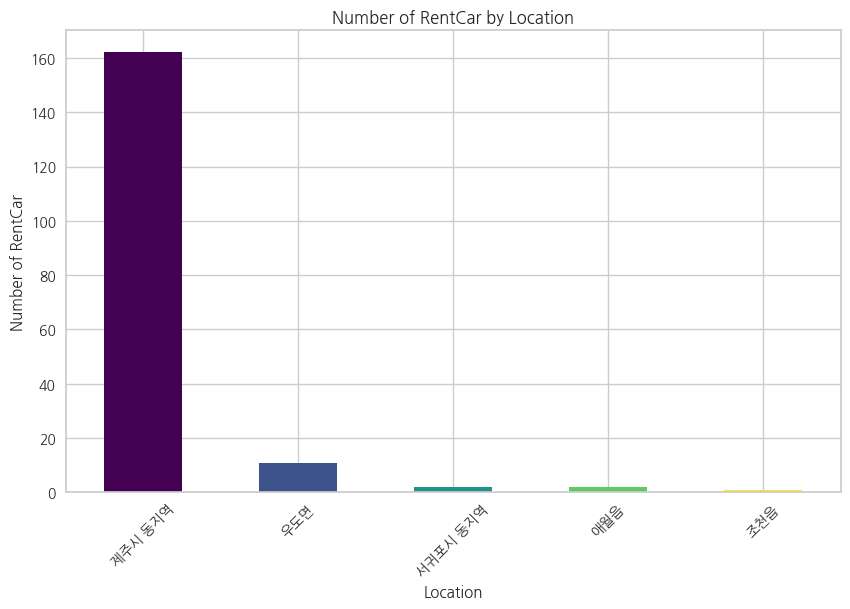

In [113]:
# location별 자전거 & 렌트카 개수 계산
car_df_counts = car_df['location'].value_counts()

# colormap 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(car_df_counts)))

# 막대 그래프 생성
plt.figure(figsize=(10, 6))
car_df_counts.plot(kind='bar', color=colors)
plt.title('Number of RentCar by Location')
plt.xlabel('Location')
plt.ylabel('Number of RentCar')
plt.xticks(rotation=45)
plt.show()

In [114]:
import folium

# 위치별로 렌트카 & 렌트카의 평균 위경도 계산
location_coords = car_df.groupby('location')[['latitude', 'longitude']].mean().reset_index()

# 렌트카 개수에 따라 색상 지정
location_counts = car_df['location'].value_counts()
quantiles = location_counts.quantile([0.25, 0.5, 0.75])

def get_color(count):
    if count > quantiles[0.75]:
        return 'red'
    elif count > quantiles[0.5]:
        return 'orange'
    elif count > quantiles[0.25]:
        return 'blue'
    else:
        return 'green'

# 지도 중심 위치 설정 (위경도의 평균 값 사용)
map_center = [location_coords['latitude'].mean(), location_coords['longitude'].mean()]

# 지도 생성
map = folium.Map(location=map_center, zoom_start=10)

# 각 위치별로 렌트카 개수를 지도에 추가
for index, row in location_coords.iterrows():
    location = row['location']
    count = car_df[car_df['location'] == location]['location'].count()  # 해당 위치의 개수 계산
    color = get_color(count)
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup=f"{location}: {count} stations",
                  icon=folium.Icon(color=color)).add_to(map)

# 지도를 HTML 파일로 저장
map.save('렌트카.html')

# 생성한 지도를 출력
map


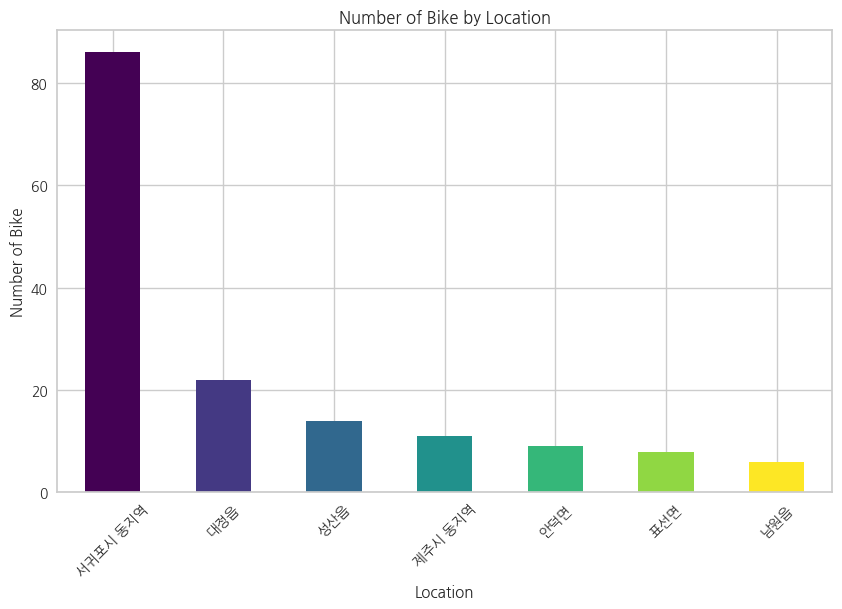

In [115]:
# location별 자전거 & 렌트카 개수 계산
bike_df_counts = bike_df['location'].value_counts()

# colormap 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(bike_df_counts)))

# 막대 그래프 생성
plt.figure(figsize=(10, 6))
bike_df_counts.plot(kind='bar', color=colors)
plt.title('Number of Bike by Location')
plt.xlabel('Location')
plt.ylabel('Number of Bike')
plt.xticks(rotation=45)
plt.show()

In [116]:
import folium

# 위치별로 자전거 & 렌트카의 평균 위경도 계산
location_coords = bike_df.groupby('location')[['latitude', 'longitude']].mean().reset_index()

# 자전거 개수에 따라 색상 지정
location_counts = bike_df['location'].value_counts()
quantiles = location_counts.quantile([0.25, 0.5, 0.75])

def get_color(count):
    if count > quantiles[0.75]:
        return 'red'
    elif count > quantiles[0.5]:
        return 'orange'
    elif count > quantiles[0.25]:
        return 'blue'
    else:
        return 'green'

# 지도 중심 위치 설정 (위경도의 평균 값 사용)
map_center = [location_coords['latitude'].mean(), location_coords['longitude'].mean()]

# 지도 생성
map = folium.Map(location=map_center, zoom_start=10)

# 각 위치별로 자전거 & 렌트카 개수를 지도에 추가
for index, row in location_coords.iterrows():
    location = row['location']
    count = bike_df[bike_df['location'] == location]['location'].count()  # 해당 위치의 개수 계산
    color = get_color(count)
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup=f"{location}: {count} stations",
                  icon=folium.Icon(color=color)).add_to(map)

# 지도를 HTML 파일로 저장
map.save('자전거.html')

# 생성한 지도를 출력
map


## 3. 음식점 & 관광지

In [117]:
df=to_dataFrame('제주관광공사_제주관광정보시스템_콘텐츠')
df

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\149725057.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,콘텐츠아이디,콘텐츠분류,제목,언어,타이틀,연관콘텐츠,지번주소,도로명주소,위도,경도,...,번체공개여부,말레이어공개여부,번체모바일사용여부,말어모바일사용여부,번체승인일시,말레이어승인일시,번체번역요청일시,말레이어번역요청일시,번체검색어자동여부,말레이어검색어자동여부
0,CNTS_000000000019943,음식점,웅스키친,국문,웅스키친,None,제주특별자치도 제주시 이호2동 116-3,제주특별자치도 제주시 대동길 17-1,33.493074,126.463770,...,None,None,None,None,None,None,None,None,None,None
1,CNTS_200000000009562,축제/행사,제주 윈터 페스티벌,국문,제주 윈터 페스티벌,None,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,n,n
2,CONT_000000000500239,관광지,법화사지,국문,법화사지,None,제주특별자치도 서귀포시 하원동 1071-1,제주특별자치도 서귀포시 하원북로35번길 15-28,33.265345,126.457683,...,y,None,y,None,None,None,2022-11-25,None,y,None
3,CNTS_000000000021945,음식점,제주기정떡,국문,제주기정떡,None,제주특별자치도 제주시 애월읍 광령리 901-4,제주특별자치도 제주시 애월읍 평화로 2747,33.449394,126.437360,...,None,None,None,None,None,None,None,None,None,None
4,CNTS_000000000018164,숙박,펄호텔제주,국문,펄호텔제주,None,제주특별자치도 제주시 연동 277-1,제주특별자치도 제주시 신대로20길 49,33.483475,126.491264,...,y,None,y,None,2019-04-23,None,2019-04-23,None,y,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7292,CNTS_300000000012958,숙박,신신호텔 제주월드컵,국문,신신호텔 제주월드컵,None,제주특별자치도 서귀포시 서호동 1524-7 신신호텔 제주월드컵,제주특별자치도 서귀포시 서호중로 55 (서호동) 신신호텔 제주월드컵,33.254560,126.519230,...,None,None,None,None,None,None,None,None,n,n
7293,CNTS_300000000012945,쇼핑,곶밭마켓&스튜디오,국문,곶밭마켓&스튜디오,None,제주특별자치도 서귀포시 상예동 3713-1 적벽돌 2층 건물,제주특별자치도 서귀포시 일주서로 1262 (상예동) 적벽돌 2층 건물,33.264671,126.378528,...,None,None,None,None,None,None,None,None,n,n
7294,CNTS_300000000012946,관광지,제주홀릭뮤지엄,국문,제주홀릭뮤지엄,None,제주특별자치도 제주시 애월읍 광령리 100-3 제주홀릭뮤지엄,제주특별자치도 제주시 애월읍 평화로 2835 (광령리) 제주홀릭뮤지엄,33.403414,126.450887,...,None,None,None,None,None,None,None,None,n,n
7295,CNTS_300000000012955,숙박,신신호텔 서귀포,국문,신신호텔 서귀포,None,제주특별자치도 서귀포시 서귀동 486-1 신신호텔 서귀포,"제주특별자치도 서귀포시 태평로371번길 18 (서귀동, 제주 서귀포 일성 트루엘) ...",NaN,NaN,...,None,None,None,None,None,None,None,None,n,n


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7297 entries, 0 to 7296
Data columns (total 73 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   콘텐츠아이디        7297 non-null   object 
 1   콘텐츠분류         7297 non-null   object 
 2   제목            7297 non-null   object 
 3   언어            7297 non-null   object 
 4   타이틀           7297 non-null   object 
 5   연관콘텐츠         17 non-null     object 
 6   지번주소          6178 non-null   object 
 7   도로명주소         6082 non-null   object 
 8   위도            6286 non-null   float64
 9   경도            6286 non-null   float64
 10  탐나오연동여부       7297 non-null   object 
 11  평점            5410 non-null   float64
 12  소셜네트워크주소      1462 non-null   object 
 13  조회수           7297 non-null   int64  
 14  외부검색어         38 non-null     object 
 15  좋아요수          7297 non-null   int64  
 16  리뷰수           7297 non-null   int64  
 17  북마크수          7297 non-null   int64  
 18  일정등록수         7297 non-null 

In [119]:
df.columns

Index(['콘텐츠아이디', '콘텐츠분류', '제목', '언어', '타이틀', '연관콘텐츠', '지번주소', '도로명주소', '위도',
       '경도', '탐나오연동여부', '평점', '소셜네트워크주소', '조회수', '외부검색어', '좋아요수', '리뷰수',
       '북마크수', '일정등록수', '다녀왔어요수', '웹사용여부', '모바일사용여부', '공개여부', '작성상태', '사용여부',
       '승인일시', '영문웹사용여부', '중문웹사용여부', '일문웹사용여부', '영문작성상태', '중문작성상태', '일문작성상태',
       '영문공개여부', '중문공개여부', '일문공개여부', '영문모바일사용여부', '중문모바일사용여부', '일문모바일사용여부',
       '영문승인일시', '중문승인일시', '일문승인일시', '등록자', '등록일시', '수정자', '수정일시', '소셜네트워크공유수',
       '인기점수', '트립어드바이저코드', '우편번호', '템플릿여부', '번역요청일시', '영문번역요청일시', '중문번역요청일시',
       '일문번역요청일시', '페이지검색어자동여부', '영문페이지검색어자동여부', '중문페이지검색어자동여부',
       '일문페이지검색어자동여부', '사진공유수', '번체웹사용여부', '말레이어웹사용여부', '번체작성상태', '말레이어작성상태',
       '번체공개여부', '말레이어공개여부', '번체모바일사용여부', '말어모바일사용여부', '번체승인일시', '말레이어승인일시',
       '번체번역요청일시', '말레이어번역요청일시', '번체검색어자동여부', '말레이어검색어자동여부'],
      dtype='object')

In [120]:
# 쓸만한 컬럼만 추출
df = df[["콘텐츠분류", "제목", "도로명주소", "위도", "경도", "평점", "조회수", "좋아요수", "리뷰수", "북마크수", "인기점수"]].copy()
# 결측치 확인
df.isnull().sum()

콘텐츠분류       0
제목          0
도로명주소    1215
위도       1011
경도       1011
         ... 
조회수         0
좋아요수        0
리뷰수         0
북마크수        0
인기점수      337
Length: 11, dtype: int64

In [121]:
df['콘텐츠분류'].value_counts()

콘텐츠분류
음식점      2714
관광지      1547
숙박       1328
테마여행      885
축제/행사     437
쇼핑        384
기타          2
Name: count, dtype: int64

In [122]:
df['평점'].value_counts().sort_index(ascending=False)

평점
5.0    1463
4.0     411
3.0     178
2.0       3
1.0      18
0.0    3337
Name: count, dtype: int64

### 데이터 전처리

In [123]:
# 평점 NAN 삭제
df = df.dropna(axis=0)
df.isnull().sum()

콘텐츠분류    0
제목       0
도로명주소    0
위도       0
경도       0
        ..
조회수      0
좋아요수     0
리뷰수      0
북마크수     0
인기점수     0
Length: 11, dtype: int64

In [124]:
df.rename(columns={'제목': '점포 이름'}, inplace=True)
df.rename(columns={'위도': 'latitude'}, inplace=True)
df.rename(columns={'경도': 'longitude'}, inplace=True)
df.rename(columns={'도로명주소': 'stationAddress'}, inplace=True)

In [125]:
# 음식점과 관광지를 모두 포함한 행 필터링
음식점_관광지_df = df[df['콘텐츠분류'].isin(['음식점', '관광지'])]

# 평점이 5.0인 가게만 선택
음식점_관광지_df = 음식점_관광지_df[음식점_관광지_df['평점'] == 5.0].reset_index(drop=True)

# 상위 10개 행 출력
음식점_관광지_df.head(10)

,콘텐츠분류,점포 이름,stationAddress,latitude,longitude,평점,조회수,좋아요수,리뷰수,북마크수,인기점수
0,음식점,웅스키친,제주특별자치도 제주시 대동길 17-1,33.493074,126.463770,5.0,5636,0,9,36,11317.0
1,관광지,법화사지,제주특별자치도 서귀포시 하원북로35번길 15-28,33.265345,126.457683,5.0,6071,2,3,20,12163.0
2,음식점,쉬림프봉봉&올레파머스,제주특별자치도 제주시 구좌읍 월정7길 57,33.555250,126.795820,5.0,2686,0,4,5,5392.0
3,관광지,보롬왓,제주특별자치도 서귀포시 표선면 번영로 2350-104,33.413670,126.753510,5.0,109633,29,57,1071,219638.0
4,관광지,귀빈사,제주특별자치도 제주시 구좌읍 비자림로 1456,33.442902,126.761325,5.0,9385,1,1,35,18778.0
5,관광지,너븐숭이 4.3기념관,제주특별자치도 제주시 조천읍 북촌3길 3,33.545986,126.688770,5.0,42514,11,40,95,85261.0
6,관광지,천지연폭포,제주특별자치도 서귀포시 남성중로 2-15,33.244717,126.559820,5.0,415918,95,210,2682,833171.0
7,관광지,서귀포자연휴양림,제주특별자치도 서귀포시 1100로 882,33.311670,126.458760,5.0,27166,7,12,181,54413.0
8,관광지,백약이오름,제주특별자치도 서귀포시 표선면 성읍리 산 1,33.437283,126.790180,5.0,83874,6,59,330,168061.0
9,음식점,돌하르방식당,제주특별자치도 제주시 한림읍 한림로 300,33.387994,126.239784,5.0,6220,0,1,32,12445.0


In [126]:
top_place_df = 음식점_관광지_df.sort_values('인기점수', ascending=False).reset_index(drop=True)
top_place_df

,콘텐츠분류,점포 이름,stationAddress,latitude,longitude,평점,조회수,좋아요수,리뷰수,북마크수,인기점수
0,관광지,사려니숲길,제주특별자치도 제주시 조천읍 교래리 산 137-1,33.408450,126.639760,5.0,813490,255,509,3656,1630290.0
1,관광지,우도(해양도립공원),제주특별자치도 제주시 우도면 삼양고수물길 1,33.519490,126.951090,5.0,743743,233,596,2788,1491165.0
2,관광지,성산일출봉(UNESCO 세계자연유산),제주특별자치도 서귀포시 성산읍 일출로 284-12,33.462147,126.936424,5.0,700427,374,611,4518,1405031.0
3,관광지,비자림,제주특별자치도 제주시 구좌읍 비자숲길 55,33.491318,126.811386,5.0,634327,91,219,2425,1270022.0
4,관광지,천지연폭포,제주특별자치도 서귀포시 남성중로 2-15,33.244717,126.559820,5.0,415918,95,210,2682,833171.0
...,...,...,...,...,...,...,...,...,...,...,...
1056,음식점,홉히,제주특별자치도 제주시 서해안로 468-2,33.518573,126.489282,5.0,46,0,1,1,97.0
1057,음식점,회심,제주특별자치도 제주시 아봉로 200,33.449525,126.574328,5.0,39,0,1,0,83.0
1058,음식점,행운문,제주특별자치도 제주시 애월읍 봉성로2길 34-3,33.364338,126.355203,5.0,27,0,2,2,64.0
1059,음식점,귤하르방,제주특별자치도,0.000000,0.000000,5.0,3,0,5,0,6.0


### 도로명 주소 및 행정구역 컬럼 생성

In [127]:
top_place_df['emd']=''

# 데이터프레임의 'stationAddress' 열에서 각 지명이 포함된 행을 찾고 'emd' 컬럼에 해당 위치를 할당합니다.
for location in seogwipo_dong + jeju_dong + jeju_eup:
    mask = top_place_df['stationAddress'].str.contains(location)
    if mask.any():
        # 해당 지명이 포함된 행의 인덱스를 가져옵니다.
        indices = top_place_df[mask].index
        
        # 해당 행들의 'emd' 컬럼에 해당 위치를 할당합니다.
        top_place_df.loc[indices, 'emd'] = location

# 'location' 컬럼 추가
top_place_df['location'] = top_place_df['emd'].apply(get_admin_location)
top_place_df

,콘텐츠분류,점포 이름,stationAddress,latitude,longitude,평점,조회수,좋아요수,리뷰수,북마크수,인기점수,emd,location
0,관광지,사려니숲길,제주특별자치도 제주시 조천읍 교래리 산 137-1,33.408450,126.639760,5.0,813490,255,509,3656,1630290.0,조천읍,조천읍
1,관광지,우도(해양도립공원),제주특별자치도 제주시 우도면 삼양고수물길 1,33.519490,126.951090,5.0,743743,233,596,2788,1491165.0,우도면,우도면
2,관광지,성산일출봉(UNESCO 세계자연유산),제주특별자치도 서귀포시 성산읍 일출로 284-12,33.462147,126.936424,5.0,700427,374,611,4518,1405031.0,성산읍,성산읍
3,관광지,비자림,제주특별자치도 제주시 구좌읍 비자숲길 55,33.491318,126.811386,5.0,634327,91,219,2425,1270022.0,구좌읍,구좌읍
4,관광지,천지연폭포,제주특별자치도 서귀포시 남성중로 2-15,33.244717,126.559820,5.0,415918,95,210,2682,833171.0,서귀포시,서귀포시 동지역
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,음식점,홉히,제주특별자치도 제주시 서해안로 468-2,33.518573,126.489282,5.0,46,0,1,1,97.0,제주시,제주시 동지역
1057,음식점,회심,제주특별자치도 제주시 아봉로 200,33.449525,126.574328,5.0,39,0,1,0,83.0,제주시,제주시 동지역
1058,음식점,행운문,제주특별자치도 제주시 애월읍 봉성로2길 34-3,33.364338,126.355203,5.0,27,0,2,2,64.0,애월읍,애월읍
1059,음식점,귤하르방,제주특별자치도,0.000000,0.000000,5.0,3,0,5,0,6.0,,None


In [128]:
top_place_df.dropna(inplace=True)
top_place_df.isna().sum()

콘텐츠분류             0
점포 이름             0
stationAddress    0
latitude          0
longitude         0
                 ..
리뷰수               0
북마크수              0
인기점수              0
emd               0
location          0
Length: 13, dtype: int64

In [129]:
top_place_df

,콘텐츠분류,점포 이름,stationAddress,latitude,longitude,평점,조회수,좋아요수,리뷰수,북마크수,인기점수,emd,location
0,관광지,사려니숲길,제주특별자치도 제주시 조천읍 교래리 산 137-1,33.408450,126.639760,5.0,813490,255,509,3656,1630290.0,조천읍,조천읍
1,관광지,우도(해양도립공원),제주특별자치도 제주시 우도면 삼양고수물길 1,33.519490,126.951090,5.0,743743,233,596,2788,1491165.0,우도면,우도면
2,관광지,성산일출봉(UNESCO 세계자연유산),제주특별자치도 서귀포시 성산읍 일출로 284-12,33.462147,126.936424,5.0,700427,374,611,4518,1405031.0,성산읍,성산읍
3,관광지,비자림,제주특별자치도 제주시 구좌읍 비자숲길 55,33.491318,126.811386,5.0,634327,91,219,2425,1270022.0,구좌읍,구좌읍
4,관광지,천지연폭포,제주특별자치도 서귀포시 남성중로 2-15,33.244717,126.559820,5.0,415918,95,210,2682,833171.0,서귀포시,서귀포시 동지역
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,음식점,오드씽,제주특별자치도 제주시 고다시길 25,33.461831,126.526856,5.0,58,0,1,2,121.0,제주시,제주시 동지역
1056,음식점,홉히,제주특별자치도 제주시 서해안로 468-2,33.518573,126.489282,5.0,46,0,1,1,97.0,제주시,제주시 동지역
1057,음식점,회심,제주특별자치도 제주시 아봉로 200,33.449525,126.574328,5.0,39,0,1,0,83.0,제주시,제주시 동지역
1058,음식점,행운문,제주특별자치도 제주시 애월읍 봉성로2길 34-3,33.364338,126.355203,5.0,27,0,2,2,64.0,애월읍,애월읍


In [130]:
# 'location'에 따른 각 행정구역의 음식점 & 관광지 수 계산
음식점_관광지_counts = top_place_df['location'].value_counts()
음식점_관광지_counts

location
제주시 동지역     226
서귀포시 동지역    155
구좌읍         102
안덕면          88
성산읍          71
           ... 
대정읍          47
표선면          46
한경면          44
남원읍          37
추자면           6
Name: count, Length: 14, dtype: int64

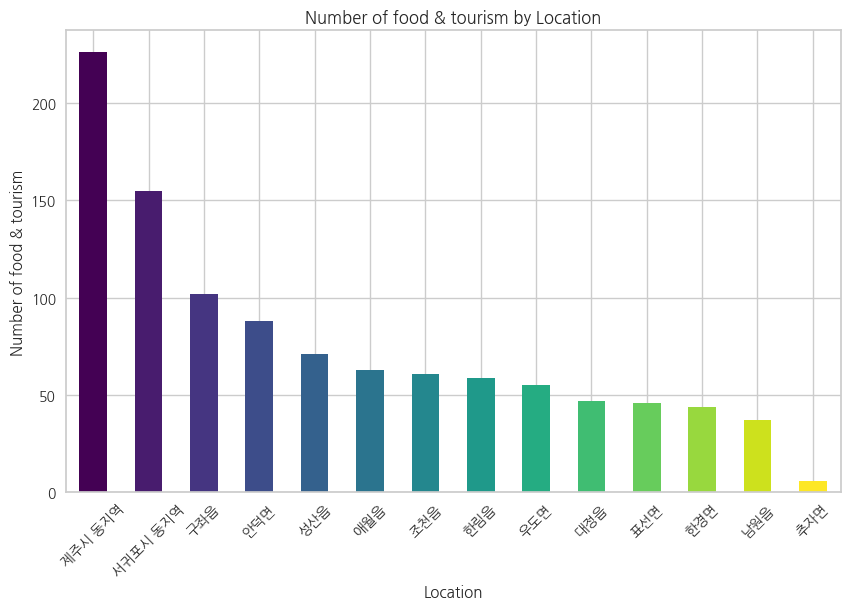

In [131]:
# location별 food_tourism 개수 계산
food_tourism_counts = top_place_df['location'].value_counts()

# colormap 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(food_tourism_counts)))

# 막대 그래프 생성
plt.figure(figsize=(10, 6))
food_tourism_counts.plot(kind='bar', color=colors)
plt.title('Number of food & tourism by Location')
plt.xlabel('Location')
plt.ylabel('Number of food & tourism')
plt.xticks(rotation=45)
plt.show()

In [132]:
from sklearn.covariance import EllipticEnvelope

# 'latitude'와 'longitude' 열을 숫자형으로 변환
top_place_df['latitude'] = top_place_df['latitude'].astype(float)
top_place_df['longitude'] = top_place_df['longitude'].astype(float)

# 이상치 감지 함수 정의
def detect_outliers(data):
    envelope = EllipticEnvelope(contamination=0.01)  # 이상치 비율 설정
    envelope.fit(data)
    outliers = envelope.predict(data)
    return outliers

# 위치별로 정류장의 평균 위경도 계산
location_coords = top_place_df.groupby('location')[['latitude', 'longitude']].mean().reset_index()

# 이상치 감지
outliers = detect_outliers(location_coords[['latitude', 'longitude']])

# 이상치가 아닌 데이터만 선택
location_coords = location_coords[outliers == 1]

# food & tourism 개수에 따라 색상 지정
location_counts = top_place_df['location'].value_counts()
quantiles = location_counts.quantile([0.25, 0.5, 0.75])

def get_color(count):
    if count > quantiles[0.75]:
        return 'red'
    elif count > quantiles[0.5]:
        return 'orange'
    elif count > quantiles[0.25]:
        return 'blue'
    else:
        return 'green'

# 지도 중심 위치 설정 (위경도의 평균 값 사용)
map_center = [location_coords['latitude'].mean(), location_coords['longitude'].mean()]

# 지도 생성
map = folium.Map(location=map_center, zoom_start=10)

# 각 위치별로 food & tourism 개수를 지도에 추가
for index, row in location_coords.iterrows():
    location = row['location']
    count = top_place_df[top_place_df['location'] == location]['location'].count()  # 해당 위치의 food & tourism 개수 계산
    color = get_color(count)
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup=f"{location}: {count} stations",
                  icon=folium.Icon(color=color)).add_to(map)

# 지도를 HTML 파일로 저장
map.save('음식점&관광지.html')

# 생성한 지도를 출력
map


## 4. 행정구역별 전체 현황

In [133]:
bike_df['구분']='bike'
car_df['구분']='car'
bus_df['구분']='bus'
top_place_df['구분']='음식점&관광지'

# 'location' 열과 '구분' 열만 추출하여 병합할 데이터프레임들을 준비합니다.
bike_locations = bike_df[['location', '구분']]
car_locations = car_df[['location', '구분']]
bus_locations = bus_df[['location', '구분']]
top_place_df_locations = top_place_df[['location', '구분']]

# 데이터프레임들을 병합합니다.
merge_df = pd.concat([bike_locations, car_locations, bus_locations, top_place_df_locations])
cross_tab = pd.crosstab(merge_df['location'], merge_df['구분'])

# 두 데이터프레임 병합
merged_df = pd.merge(cross_tab, jesu_population_df, on='location', how='inner')

merged_df = merged_df.drop(['장소', '도로명주소', 'latitude', 'longitude'], axis=1)

# totalPop 열을 10000000 (천만) 나누어서 업데이트합니다.
merged_df['totalPop'] = round(merged_df['totalPop'] // 10000000,0)
merged_df.rename(columns={'totalPop': '인구'}, inplace=True)
merged_df

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\736596641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['구분']='car'


,location,bike,bus,car,음식점&관광지,인구
0,구좌읍,0,236,0,102,55
1,남원읍,6,297,0,37,58
2,대정읍,22,165,0,47,66
3,서귀포시 동지역,86,675,2,155,335
4,성산읍,14,225,0,71,59
...,...,...,...,...,...,...
9,조천읍,0,320,1,61,81
10,추자면,0,0,0,6,6
11,표선면,8,222,0,46,44
12,한경면,0,204,0,44,29


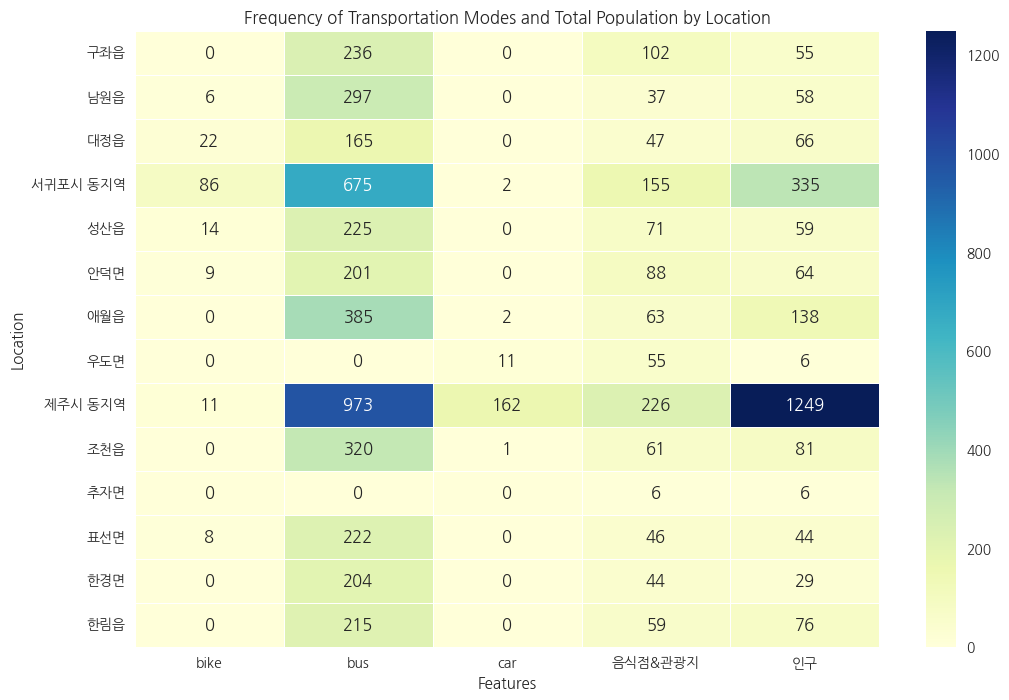

In [134]:
# 시각화: 히트맵으로 데이터프레임 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df.set_index('location'), cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)
plt.title('Frequency of Transportation Modes and Total Population by Location')
plt.xlabel('Features')
plt.ylabel('Location')
plt.show()

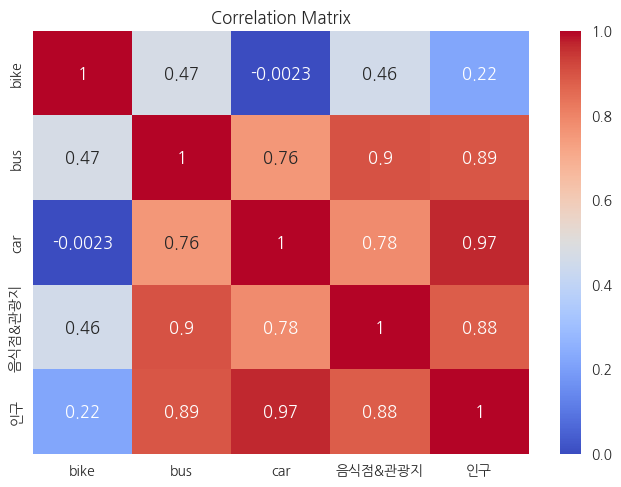

In [135]:
# 상관 행렬 시각화
corr_matrix = merged_df[['bike', 'bus', 'car', '음식점&관광지', '인구']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [136]:
jesu_population_df[['location', 'latitude', 'longitude']]

,location,latitude,longitude
0,구좌읍,33.5250247566996,126.816164035762
1,애월읍,33.4486238312794,126.387472960383
2,우도면,33.4925956178596,126.964240571646
3,제주시 동지역,33.5059364682672,126.495951277797
4,조천읍,33.4996730708539,126.662508048026
...,...,...,...
9,대정읍,33.2386106145828,126.258210198215
10,서귀포시 동지역,33.2598740836071,126.501775286788
11,성산읍,33.4294862344343,126.855127407133
12,안덕면,33.2828926479524,126.359168662669


In [137]:
merged_df

,location,bike,bus,car,음식점&관광지,인구
0,구좌읍,0,236,0,102,55
1,남원읍,6,297,0,37,58
2,대정읍,22,165,0,47,66
3,서귀포시 동지역,86,675,2,155,335
4,성산읍,14,225,0,71,59
...,...,...,...,...,...,...
9,조천읍,0,320,1,61,81
10,추자면,0,0,0,6,6
11,표선면,8,222,0,46,44
12,한경면,0,204,0,44,29


In [138]:
# 두 데이터프레임 병합
merged_df2 = pd.merge(left=jesu_population_df[['location', 'latitude', 'longitude']], right=merged_df, on='location')
merged_df2

,location,latitude,longitude,bike,bus,car,음식점&관광지,인구
0,구좌읍,33.5250247566996,126.816164035762,0,236,0,102,55
1,애월읍,33.4486238312794,126.387472960383,0,385,2,63,138
2,우도면,33.4925956178596,126.964240571646,0,0,11,55,6
3,제주시 동지역,33.5059364682672,126.495951277797,11,973,162,226,1249
4,조천읍,33.4996730708539,126.662508048026,0,320,1,61,81
...,...,...,...,...,...,...,...,...
9,대정읍,33.2386106145828,126.258210198215,22,165,0,47,66
10,서귀포시 동지역,33.2598740836071,126.501775286788,86,675,2,155,335
11,성산읍,33.4294862344343,126.855127407133,14,225,0,71,59
12,안덕면,33.2828926479524,126.359168662669,9,201,0,88,64


In [139]:
# 데이터프레임을 복사하여 순위를 계산할 데이터프레임 생성
ranking_df = merged_df2.copy()

# 각 열에 대해 랭킹 계산
ranking_df['bike_rank'] = ranking_df['bike'].rank(ascending=False)
ranking_df['bus_rank'] = ranking_df['bus'].rank(ascending=False)
ranking_df['car_rank'] = ranking_df['car'].rank(ascending=False)
ranking_df['food_tourism_rank'] = ranking_df['음식점&관광지'].rank(ascending=False)
ranking_df['population_rank'] = ranking_df['인구'].rank(ascending=False)

# 각 요소의 상대적 중요도 설정 (예: 가중치)
weights = {
    'bike': 0.22,
    'bus': 0.89,
    'car': 0.97,
    '음식점&관광지': 0.88,
    '인구': 1
}

# 데이터 정규화
normalized_df = ranking_df[['bike', 'bus', 'car', '음식점&관광지', '인구']] / ranking_df[['bike', 'bus', 'car', '음식점&관광지', '인구']].max()

# 각 요소에 가중치를 곱하여 최종 점수 계산
weighted_scores = normalized_df * pd.Series(weights)

# 최종 점수 계산
ranking_df['final_score'] = weighted_scores.sum(axis=1)

ranking_df['final_rank']=ranking_df['final_score'].rank(ascending=False)
ranking_df

,location,latitude,longitude,bike,bus,car,음식점&관광지,인구,bike_rank,bus_rank,car_rank,food_tourism_rank,population_rank,final_score,final_rank
0,구좌읍,33.5250247566996,126.816164035762,0,236,0,102,55,11.0,6.0,10.0,3.0,10.0,0.657072,4.0
1,애월읍,33.4486238312794,126.387472960383,0,385,2,63,138,11.0,3.0,3.5,6.0,3.0,0.719932,3.0
2,우도면,33.4925956178596,126.964240571646,0,0,11,55,6,11.0,13.5,2.0,9.0,13.5,0.284827,13.0
3,제주시 동지역,33.5059364682672,126.495951277797,11,973,162,226,1249,4.0,1.0,1.0,1.0,1.0,3.768140,1.0
4,조천읍,33.4996730708539,126.662508048026,0,320,1,61,81,11.0,4.0,5.0,7.0,4.0,0.601065,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,대정읍,33.2386106145828,126.258210198215,22,165,0,47,66,2.0,12.0,10.0,10.0,6.0,0.443055,10.0
10,서귀포시 동지역,33.2598740836071,126.501775286788,86,675,2,155,335,1.0,2.0,3.5,2.0,2.0,1.721150,2.0
11,성산읍,33.4294862344343,126.855127407133,14,225,0,71,59,3.0,7.0,10.0,5.0,8.0,0.565319,7.0
12,안덕면,33.2828926479524,126.359168662669,9,201,0,88,64,5.0,11.0,10.0,4.0,7.0,0.600773,6.0


In [140]:

# 색상 매핑 함수 정의
def get_marker_color(rank, quartiles):
    """
    quartiles: total_rank의 사분위수 리스트 [Q1, Q2, Q3]
    """
    if rank <= quartiles[0]:
        return 'green'  # 1사분위
    elif rank <= quartiles[1]:
        return 'blue'  # 2사분위
    elif rank <= quartiles[2]:
        return 'orange'  # 3사분위
    else:   
        return 'red'  # 4사분위

# 제주도의 중심 좌표 설정
map_center = [33.3761, 126.5286]

# 지도 객체 생성
map_visualization = folium.Map(location=map_center, zoom_start=10)

# final_rank의 사분위수 계산
quartiles = ranking_df['final_rank'].quantile([0.25, 0.5, 0.75]).values

# 데이터프레임의 각 행에 대해 반복하면서 마커를 추가
for index, row in ranking_df.iterrows():
    location = [row['latitude'], row['longitude']]  # 위도와 경도 정보
    
    # 마커에 표시될 팝업 설정 (행정구역과 관련된 정보)
    popup = f"""
    <b>Location:</b> {row['location']}<br>
    <b>Bike:</b> {row['bike']}<br>
    <b>Bus:</b> {row['bus']}<br>
    <b>Car:</b> {row['car']}<br>
    <b>Food & Tourism:</b> {row['음식점&관광지']}<br>
    <b>Population:</b> {row['인구']}<br>
    <b>final_rank:</b> {row['final_rank']}
    """
    
    # total_rank를 기준으로 마커 색상 선택
    marker_color = get_marker_color(row['final_rank'], quartiles)
    
    # 마커 생성 및 지도에 추가
    folium.Marker(location=location, popup=popup, icon=folium.Icon(color=marker_color)).add_to(map_visualization)

map_visualization.save('행정구역별.html')
# 지도 출력
map_visualization


# 결론

In [176]:
bus_df = to_dataFrame('월별버스이용자유형별패널티현황')

# '연월' 열의 데이터 타입을 문자열로 변환
bus_df['연월'] = bus_df['연월'].astype(str)
# 연도와 월을 나눠서 새로운 열 추가
bus_df['연도'] = bus_df['연월'].str[:4]  # 연도 추출
bus_df['월'] = bus_df['연월'].str[4:]    # 월 추출

filtered_df = bus_df[(bus_df['교통 수단 구분'].str.contains('간선')) & (bus_df['연도'] >= '2021')]
filtered_df

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\149725057.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,연월,교통 수단 구분,이용자 구분,패널티 수,이용자 수,연도,월
1371,202101,"간선(일반, 제주, 서귀포)",경로,0,334707,2021,01
1372,202101,"간선(일반, 제주, 서귀포)",어린이,32,19218,2021,01
1373,202101,"간선(일반, 제주, 서귀포)",유공 동반,0,69,2021,01
1374,202101,"간선(일반, 제주, 서귀포)",유공 일반,0,12634,2021,01
1375,202101,"간선(일반, 제주, 서귀포)",일반,4323,1546957,2021,01
...,...,...,...,...,...,...,...
2676,202311,"간선(일반, 제주, 서귀포)",유공 일반,0,8771,2023,11
2677,202311,"간선(일반, 제주, 서귀포)",일반,4448,1393597,2023,11
2678,202311,"간선(일반, 제주, 서귀포)",장애 동반,0,62774,2023,11
2679,202311,"간선(일반, 제주, 서귀포)",장애 일반,0,58742,2023,11


In [376]:
ne_df = to_dataFrame('제주특별자치도_제주시내버스노선현황')
ne_df2 = to_dataFrame('제주특별자치도_서귀포시내버스노선현황')

C:\Users\fxpow\AppData\Local\Temp\ipykernel_9316\149725057.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [377]:
result_df_jeju=jeju_admin_district_df[jeju_admin_district_df['location']=='제주시 동지역']
result_df_seogwipo=jeju_admin_district_df[jeju_admin_district_df['location']=='서귀포시 동지역']

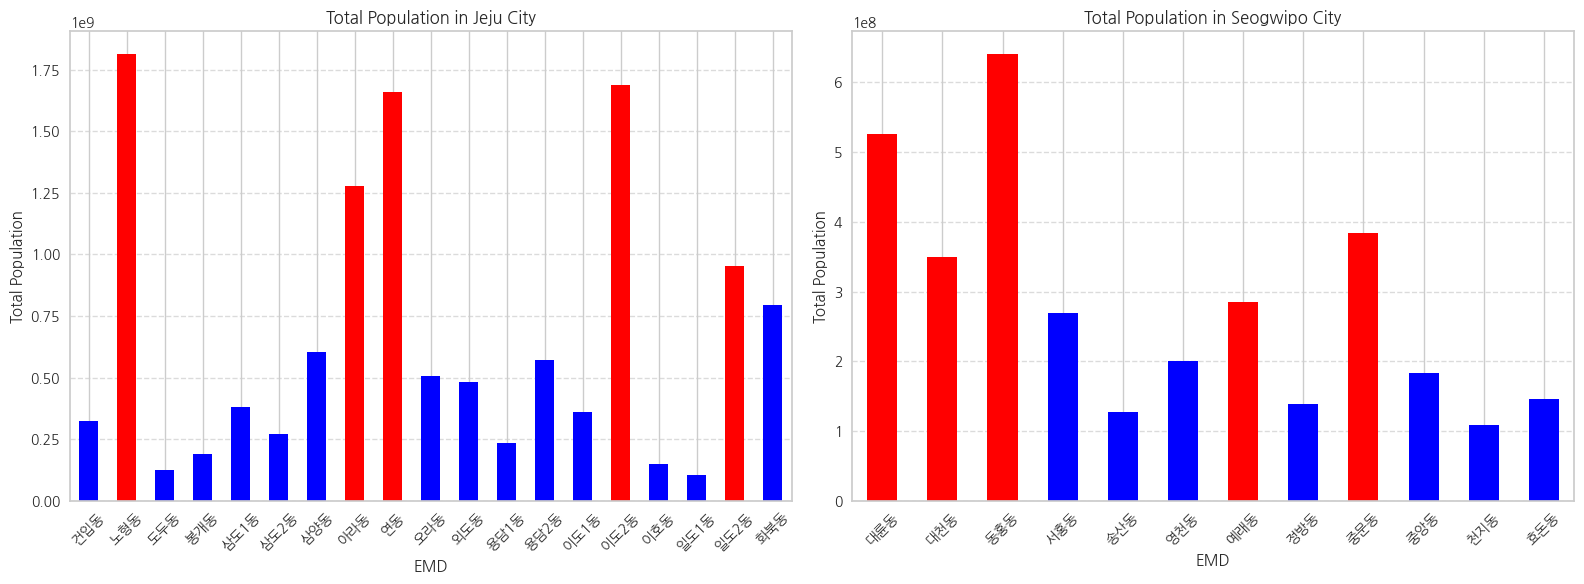

In [378]:
# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 제주시 데이터 그래프
total_pop_by_emd_jeju = result_df_jeju.groupby('emd')['totalPop'].sum()  # 제주시 데이터프레임에 대한 변수명 변경
top_5_jeju = total_pop_by_emd_jeju.nlargest(5)
colors_jeju = ['red' if emd in top_5_jeju.index else 'blue' for emd in total_pop_by_emd_jeju.index]
total_pop_by_emd_jeju.plot(kind='bar', color=colors_jeju, ax=axes[0])  # 변수명 변경
axes[0].set_title('Total Population in Jeju City')
axes[0].set_xlabel('EMD')
axes[0].set_ylabel('Total Population')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 서귀포시 데이터 그래프
total_pop_by_emd_seogwipo = result_df_seogwipo.groupby('emd')['totalPop'].sum()  # 서귀포시 데이터프레임에 대한 변수명 변경
top_5_seogwipo = total_pop_by_emd_seogwipo.nlargest(5)
colors_seogwipo = ['red' if emd in top_5_seogwipo.index else 'blue' for emd in total_pop_by_emd_seogwipo.index]
total_pop_by_emd_seogwipo.plot(kind='bar', color=colors_seogwipo, ax=axes[1])  # 변수명 변경
axes[1].set_title('Total Population in Seogwipo City')
axes[1].set_xlabel('EMD')
axes[1].set_ylabel('Total Population')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


({'대륜동', '대천동', '동홍동', '예래동', '중문동'}, {'노형동', '아라동', '연동', '이도2동', '일도2동'})

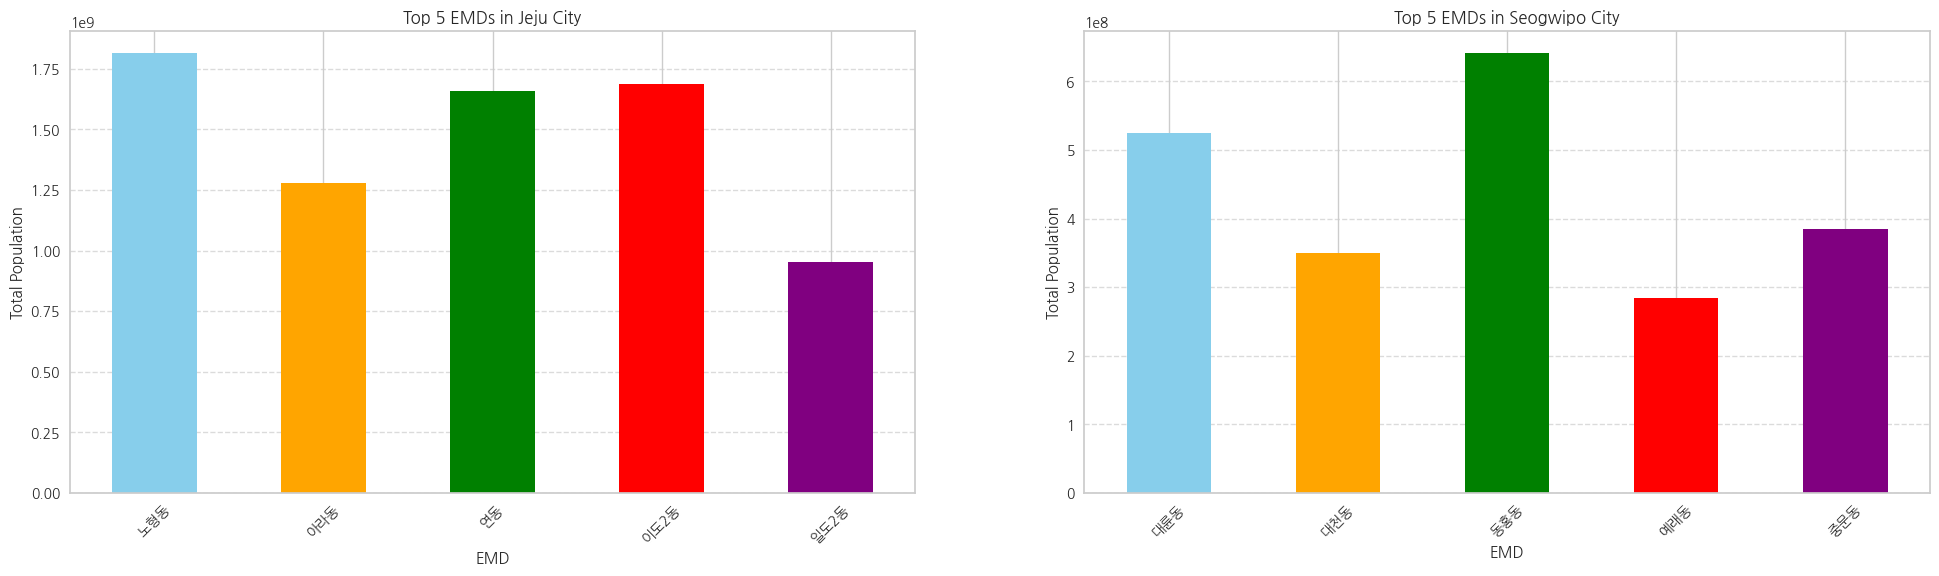

In [379]:
# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# 제주시 상위 5개 동 추출 및 데이터프레임 생성
top_5_jeju_df = result_df_jeju[result_df_jeju['emd'].isin(top_5_jeju.index)]
colors_jeju = ['skyblue', 'orange', 'green', 'red', 'purple']  # 상위 5개 동마다 다른 색상 지정
top_5_jeju_df.groupby('emd')['totalPop'].sum().plot(kind='bar', color=colors_jeju, ax=axes[0])
axes[0].set_title('Top 5 EMDs in Jeju City')
axes[0].set_xlabel('EMD')
axes[0].set_ylabel('Total Population')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 서귀포시 상위 5개 동 추출 및 데이터프레임 생성
top_5_seogwipo_df = result_df_seogwipo[result_df_seogwipo['emd'].isin(top_5_seogwipo.index)]
colors_seogwipo = ['skyblue', 'orange', 'green', 'red', 'purple']  # 상위 5개 동마다 다른 색상 지정
top_5_seogwipo_df.groupby('emd')['totalPop'].sum().plot(kind='bar', color=colors_seogwipo, ax=axes[1])
axes[1].set_title('Top 5 EMDs in Seogwipo City')
axes[1].set_xlabel('EMD')
axes[1].set_ylabel('Total Population')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

set(top_5_seogwipo_df['emd']),set(top_5_jeju_df['emd'])

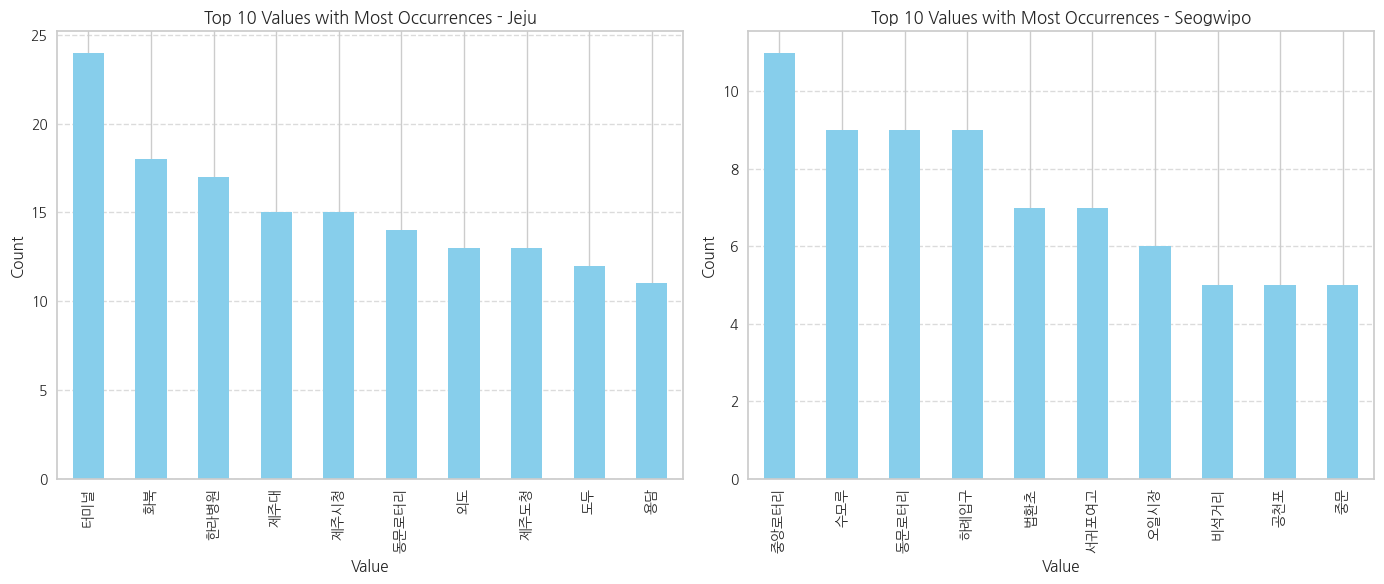

In [380]:
import matplotlib.pyplot as plt

# 제주
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 위치
# 운행구간 컬럼을 가져오기
운행구간_series_jeju = ne_df['운행구간']
# '-' 기준으로 스플릿하여 데이터프레임 만들기
운행구간_split_df_jeju = 운행구간_series_jeju.str.split('-', expand=True)
# 모든 값을 하나의 시리즈로 합치기
values_series_jeju = 운행구간_split_df_jeju.values.ravel()
# 중복된 값들을 찾고, 순서대로 나열하고 몇 번 언급되었는지 카운트
duplicates_jeju = pd.Series(values_series_jeju).value_counts()
# 상위 10개 중복된 항목 필터링
filtered_result_jeju = duplicates_jeju.head(10)
# 막대그래프로 표시
filtered_result_jeju.plot(kind='bar', color='skyblue')
# 그래프 제목과 축 라벨 설정
plt.title('Top 10 Values with Most Occurrences - Jeju')
plt.xlabel('Value')
plt.ylabel('Count')
# 그리드 추가
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 서귀포
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 위치
# 운행구간 컬럼을 가져오기
운행구간_se_series_seogwipo = ne_df2['운행구간']
# '-' 기준으로 스플릿하여 데이터프레임 만들기
운행구간_split_df_seogwipo = 운행구간_se_series_seogwipo.str.split('-', expand=True)
# 모든 값을 하나의 시리즈로 합치기
values_series_seogwipo = 운행구간_split_df_seogwipo.values.ravel()
# 중복된 값들을 찾고, 순서대로 나열하고 몇 번 언급되었는지 카운트
duplicates_seogwipo = pd.Series(values_series_seogwipo).value_counts()
# 상위 10개 중복된 항목 필터링
filtered_result_seogwipo = duplicates_seogwipo.head(10)
# 막대그래프로 표시
filtered_result_seogwipo.plot(kind='bar', color='skyblue')
# 그래프 제목과 축 라벨 설정
plt.title('Top 10 Values with Most Occurrences - Seogwipo')
plt.xlabel('Value')
plt.ylabel('Count')
# 그리드 추가
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.tight_layout()
plt.show()

In [381]:
# 키워드의 최소 개수 설정
min_keyword_count = 4  # 이 값 이상의 키워드가 운행구간에 포함된 경우 출력

# 운행구간에 특정 문자열이 포함된 데이터 찾기
for index, row in ne_df.iterrows():
    keyword_count = 0  # 키워드 개수 초기화
    for keyword in filtered_result_jeju.index:
        if keyword in row['운행구간']:
            keyword_count += 1  # 키워드가 발견될 때마다 개수 증가
            if keyword_count >= min_keyword_count:
                print(f"제주 노선명: {row['노선명']}, 운행구간: {row['운행구간']}, 포함된 키워드 개수: {keyword_count}")
                break  # 최소 키워드 개수에 도달한 경우 검색 중지

# 운행구간에 특정 문자열이 포함된 데이터 찾기
for index, row in ne_df2.iterrows():
    keyword_count = 0  # 키워드 개수 초기화
    for keyword in filtered_result_seogwipo.index:
        if keyword in row['운행구간']:
            keyword_count += 1  # 키워드가 발견될 때마다 개수 증가
            if keyword_count >= min_keyword_count:
                print(f"서귀포 노선명: {row['노선명']}, 운행구간: {row['운행구간']}, 포함된 키워드 개수: {keyword_count}")
                break  # 최소 키워드 개수에 도달한 경우 검색 중지


제주 노선명: 311, 운행구간: 한라수목원-탐라도서관-노형오거리-한라병원-제원아파트-제주도청-보건소-제주시청-화북-삼양-함덕, 포함된 키워드 개수: 4
제주 노선명: 312, 운행구간: 한라수목원-탐라도서관-노형오거리-한라병원-제원아파트-제주도청-보건소-광양-동문로터리-화북-삼화지구-함덕, 포함된 키워드 개수: 4
제주 노선명: 315, 운행구간: 수산-하귀-외도-월광로-백록초-원노형-매종글래드-제주도청-제주공항-터미널-광양사거리-동문로터리-국제부두, 포함된 키워드 개수: 4
제주 노선명: 316, 운행구간: 번대-하귀-외도-오광로-백록초-원노형-매종글래드-제주도청(신제주R)-제주공항-용담사거리-동문로터리-화북-삼양, 포함된 키워드 개수: 4
제주 노선명: 335, 운행구간: 관광대-백록초-한라병원-제원아파트-제주도청-터미널-동광양-인제-화북-삼양-봉개, 포함된 키워드 개수: 4
제주 노선명: 351, 운행구간: 제주대-제주시청-중앙로사거리-동문로터리-인화동-국립박물관-화북-삼양-봉개(회천), 포함된 키워드 개수: 4
제주 노선명: 352, 운행구간: 제주대-제주시청-중앙로사거리-동문로터리-사라봉-국립박물관-화북-삼양-봉개, 포함된 키워드 개수: 4
제주 노선명: 355, 운행구간: 수산-하귀-외도-이호-월광로입구-월랑초-한라병원-제주도청-터미널-제주여고-제주대학교, 포함된 키워드 개수: 4
제주 노선명: 356, 운행구간: 수산-하귀-외도-이호-월광로입구-월랑초-한라병원-제주도청-보건소-제주여고-제주대(영주고), 포함된 키워드 개수: 4
제주 노선명: 358, 운행구간: 수산-하귀-외도-이호-월광로입구-월랑초-한라병원-제주도청-터미널-아라초등-중앙고-월평, 포함된 키워드 개수: 4
제주 노선명: 360, 운행구간: 제주대-제주시청-터미널-제주도청-제원아파트-한라병원-노형오거리-제일고-탐라도서관-제주고(중흥S클래스), 포함된 키워드 개수: 4
제주 노선명: 365, 운행구간: 제주대(영주고)-제주시청-중앙로사거리-용담-제주공항-제주도청-제원아파트-한라병원-노

In [365]:
ne_df[ne_df['노선명'].isin([355, 360, 365])]


,구분,노선명,운행구간,거리(km),1일운행횟수,배차간격(분) (평일),운행대수 (평일),운행업체,비고,데이터기준일자
22,간선,355,수산-하귀-외도-이호-월광로입구-월랑초-한라병원-제주도청-터미널-제주여고-제주대학교,24.8,56,19~142,18,삼영교통,휴일감차,2022-12-31
26,간선,360,제주대-제주시청-터미널-제주도청-제원아파트-한라병원-노형오거리-제일고-탐라도서관-제...,16.0,166,7~20,17,삼영교통,휴일감차,2022-12-31
27,간선,365,제주대(영주고)-제주시청-중앙로사거리-용담-제주공항-제주도청-제원아파트-한라병원-노...,18.8,183,6~17,21,삼영교통,휴일감차,2022-12-31
